In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

# Set seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)
pd.set_option("display.max_columns", None)

In [11]:
# Technical indicators
trend_indicators = ["DMN_5", "DMN_10", "ADX_5", "ADX_10", "DMP_5"]
oscillators =["MACD_8_21_5", "STOCHd_7_3_3", "RSI_7"]
moving_averages = ["MA_20", "KAMA_3_2_10", "EMA_15", "MA_10"]
volatility_indicators = ["Bollinger_Lower", "Bollinger_Upper"]
other_indicators = []
technical_indicators = (
    trend_indicators + oscillators + moving_averages + volatility_indicators + other_indicators
)

# LOB specific indicators
mid_price_indicators = ["std_mid_price", "weighted_mid_price_variation", "mean_mid_price_variation"]
bid_ask_prices_indicators = ["std_spread", "mean_spread"]
volume_indicators = ["total_bid_volume", "total_ask_volume", "std_best_bid_size", "std_best_ask_size"]
orders_indicators = ["mean_order_book_imbalance", "order_book_imbalance_5s", "order_flow_5s", "last_order_book_imbalance", "total_net_order_flow"]
lob_indicators = mid_price_indicators + bid_ask_prices_indicators + volume_indicators + orders_indicators

time_indicators = ['time_since_open']

# Feature list
features =  technical_indicators + time_indicators

In [12]:
# Parameters
sampling_rate = "2s"
prediction_column = "mean_mid_price_variation_class"
batch_size = 32
look_back = 16

In [ ]:
raw_data = pd.read_parquet("all_data.parquet")

start_date = "2024-10-01"
end_date = "2024-10-30"

all_data = raw_data.loc[start_date:end_date]

all_data.head()

,mid_price_first,mid_price_last,mid_price_high,mid_price_low,mid_price_mean,std_mid_price,weighted_mid_price_first,weighted_mid_price_last,weighted_mid_price_mean,last_spread,mean_spread,std_spread,last_best_bid_price,mean_best_bid_price,last_best_ask_price,mean_best_ask_price,last_best_bid_size,mean_best_bid_size,std_best_bid_size,last_best_ask_size,mean_best_ask_size,std_best_ask_size,mean_second_ask_price,mean_second_bid_price,mid_price_variation,mid_price_variation_class,mean_mid_price_variation,mean_mid_price_variation_class,next_5_mean_mid_price_variation_class,weighted_mid_price_variation,weighted_mid_price_variation_class,total_bid_volume,total_ask_volume,mean_order_book_imbalance,last_order_book_imbalance,total_net_order_flow,num_added_orders,num_canceled_orders,num_traded_orders,order_book_imbalance_5s,order_flow_5s,bid_volume_variation,ask_volume_variation,bid_price_variation,ask_price_variation,trade_open,trade_close,trade_high,trade_low,ADX_5,ADX_7,ADX_10,DMP_5,DMP_10,DMN_5,DMN_10,AROONU_7,AROOND_7,OLL3,OLL5,OLL10,OLL15,OHH3,OHH5,STOCHk_7_3_3,STOCHd_7_3_3,MACD_8_21_5,RSI_7,AO_5_10,EMA_15,HMA_10,KAMA_3_2_10,MA_10,MA_20,rmCO(3),rmCO(4),rmCO(5),rmCO(6),Bollinger_Upper,Bollinger_Lower,U_minus_L,MA20dSTD,CO,C1O1,C2O2,C3O3,range,OH1,time_since_open,is_monday,is_tuesday,is_wednesday,is_thursday,is_friday
ts_recv,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-10-07 09:30:56-04:00,224.715,224.585,224.715,224.585,224.657938,0.038549,224.705841,224.569671,224.652563,0.05,0.034968,0.010257,224.56,224.640455,224.61,224.675422,100.0,114.389610,75.132830,417.0,223.925325,131.975164,224.685422,224.629318,-0.000579,0.0,-0.000254,0,0,-0.000606,0,-1077.0,3485.0,-0.322185,-0.613153,-317,156.0,127.0,25,-0.220301,-198.2,-10.0,162.0,0.0,0.0,224.70,224.60,224.70,224.60,56.829757,44.050740,33.425501,5.313956,12.739525,51.861940,37.785270,0.000000,100.000000,0.130,0.130,0.130,0.130,0.135,0.180,0.000000,11.030374,-0.029634,23.255558,-0.09575,224.846693,224.811285,224.769539,224.858816,224.920243,-0.080000,-0.04500,-0.060,-0.072500,225.124911,224.715575,0.409336,0.121400,-0.130,-0.090,-0.020,0.060,0.13,0.00,56.0,1,0,0,0,0
2024-10-07 09:30:58-04:00,224.585,224.510,224.585,224.445,224.514881,0.027598,224.569671,224.518169,224.513013,0.04,0.038927,0.014035,224.49,224.495417,224.53,224.534344,100.0,148.223169,168.875198,42.0,174.163543,118.837905,224.544532,224.483748,-0.000334,0.0,-0.000312,0,1,-0.000229,0,1543.0,3219.0,-0.080648,0.408451,58,279.0,236.0,72,-0.207789,-136.6,0.0,-375.0,0.0,0.0,224.56,224.52,224.56,224.47,63.021314,48.655801,36.074959,4.092404,11.269347,62.927741,44.965027,0.000000,100.000000,0.140,0.140,0.140,0.140,0.220,0.265,11.304348,6.838291,-0.042353,16.384773,-0.11950,224.805216,224.748752,224.656358,224.825188,224.897251,-0.098333,-0.07875,-0.051,-0.062500,225.165662,224.628840,0.536822,0.146803,-0.075,-0.130,-0.090,-0.020,0.14,0.00,58.0,1,0,0,0,0
2024-10-07 09:31:00-04:00,224.510,224.615,224.660,224.510,224.601400,0.032586,224.518169,224.600000,224.603488,0.05,0.035964,0.010211,224.59,224.583418,224.64,224.619382,50.0,140.978182,95.634167,200.0,103.481818,73.086386,224.630127,224.572964,0.000468,2.0,0.000407,1,1,0.000364,1,1025.0,-446.0,0.151354,-0.600000,-150,240.0,250.0,60,-0.097779,-126.4,-50.0,158.0,0.0,0.0,224.53,224.62,224.66,224.53,60.959439,48.987471,36.718641,14.898963,15.947612,48.114672,39.533714,0.000000,85.714286,0.065,0.065,0.065,0.065,0.205,0.340,37.777778,16.360709,-0.035554,30.808598,-0.12225,224.779739,224.708063,224.647722,224.784625,224.876361,-0.033333,-0.04750,-0.042,-0.025000,225.167618,224.585104,0.582514,0.158017,0.105,-0.075,-0.130,-0.090,0.15,0.00,60.0,1,0,0,0,0
2024-10-07 09:31:02-04:00,224.615,224.605,224.615,224.515,224.563345,0.025154,224.600000,224.603407,224.565389,0.03,0.035304,0.009907,224.59,224.545693,224.62,224.580998,101.0,144.600973,78.070927,125.0,132.496350,95.667192,224.593552,224.535207,-0.000045,0.0,-0.000230,0,1,0.000015,1,71

In [10]:
all_data[prediction_column].value_counts()

NameError: name 'prediction_column' is not defined

In [9]:
# Data splitting
train_size = int(len(all_data) * 0.7)
val_size = int(len(all_data) * 0.1)
test_size = len(all_data) - train_size - val_size

train_df = all_data.iloc[:train_size, :]
val_df = all_data.iloc[train_size : train_size + val_size, :]
test_df = all_data.iloc[train_size + val_size :, :]

In [10]:
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler

class ScaledTimeSeriesDataset(Dataset):
    def __init__(self, data, target, features, look_back):
        self.data = data[features].values
        self.targets = data[target].values.astype(int)
        self.features = features
        self.look_back = look_back

    def __len__(self):
        return len(self.data) - self.look_back

    def __getitem__(self, idx):
        sequence = self.data[idx : idx + self.look_back]
        target = self.targets[idx + self.look_back]

        # Apply scaling for each training example
        scaler = MinMaxScaler(feature_range=(0, 1))
        sequence = scaler.fit_transform(sequence)

        return torch.tensor(sequence, dtype=torch.float32), torch.tensor(
            target, dtype=torch.long
        )


In [11]:
# Create datasets
train_dataset = ScaledTimeSeriesDataset(train_df, prediction_column, features, look_back)
val_dataset = ScaledTimeSeriesDataset(val_df, prediction_column, features, look_back)
test_dataset = ScaledTimeSeriesDataset(test_df, prediction_column, features, look_back)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Define the PyTorch model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size1, batch_first=True)
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.dropout1 = nn.Dropout(0.2)
        self.lstm2 = nn.LSTM(hidden_size1, hidden_size2, batch_first=True)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.dropout2 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(hidden_size2, 32)
        self.dropout3 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(32, num_classes)
    
    def forward(self, x):
        x, _ = self.lstm1(x)
        x = x.permute(0, 2, 1)  # Reshape for BatchNorm
        x = self.bn1(x)
        x = x.permute(0, 2, 1)
        x = self.dropout1(x)
        x, _ = self.lstm2(x)
        x = x.permute(0, 2, 1)
        x = self.bn2(x)
        x = x.permute(0, 2, 1)
        x = self.dropout2(x)
        x = x[:, -1, :]  # Take the last time step
        x = self.fc1(x)
        x = self.dropout3(x)
        x = self.fc2(x)
        return x

In [13]:
import torch.optim as optim

# Initialize model, loss, and optimizer
input_size = len(features)
hidden_size1 = 128
hidden_size2 = 64
num_classes = len(np.unique(all_data[prediction_column]))

model = LSTMModel(input_size, hidden_size1, hidden_size2, num_classes)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001) 

In [14]:
# Training loop
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Model is on device: {next(model.parameters()).device}")

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0
    
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        # Accumulate training loss
        train_loss += loss.item()
        
        # Compute training accuracy
        _, predicted_train = torch.max(outputs.data, 1)
        total_train += batch_y.size(0)
        correct_train += (predicted_train == batch_y).sum().item()

    train_loss /= len(train_loader)
    train_acc = correct_train / total_train

    # Validation
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            val_loss += criterion(outputs, batch_y).item()
            _, predicted_val = torch.max(outputs.data, 1)
            total_val += batch_y.size(0)
            correct_val += (predicted_val == batch_y).sum().item()

    val_loss /= len(val_loader)
    val_acc = correct_val / total_val

    print(
        f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
    )


Model is on device: cpu
Epoch 1/5, Train Loss: 0.6937, Train Acc: 0.5290, Val Loss: 0.6851, Val Acc: 0.5554
Epoch 2/5, Train Loss: 0.6871, Train Acc: 0.5454, Val Loss: 0.6856, Val Acc: 0.5591
Epoch 3/5, Train Loss: 0.6853, Train Acc: 0.5499, Val Loss: 0.6841, Val Acc: 0.5550
Epoch 4/5, Train Loss: 0.6852, Train Acc: 0.5581, Val Loss: 0.6865, Val Acc: 0.5480
Epoch 5/5, Train Loss: 0.6846, Train Acc: 0.5574, Val Loss: 0.6853, Val Acc: 0.5547


Accuracy: 0.5674
              precision    recall  f1-score   support

           0       0.59      0.66      0.62      2914
           1       0.54      0.46      0.49      2520

    accuracy                           0.57      5434
   macro avg       0.56      0.56      0.56      5434
weighted avg       0.56      0.57      0.56      5434



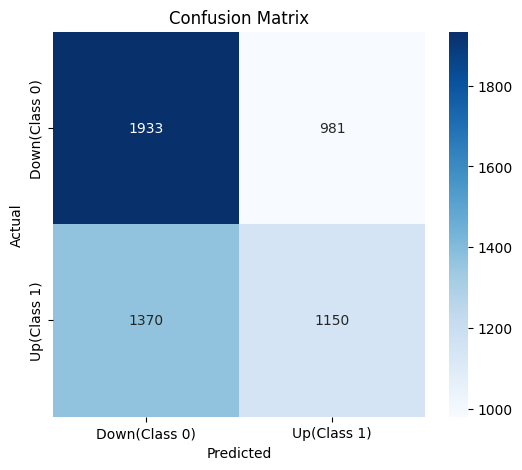

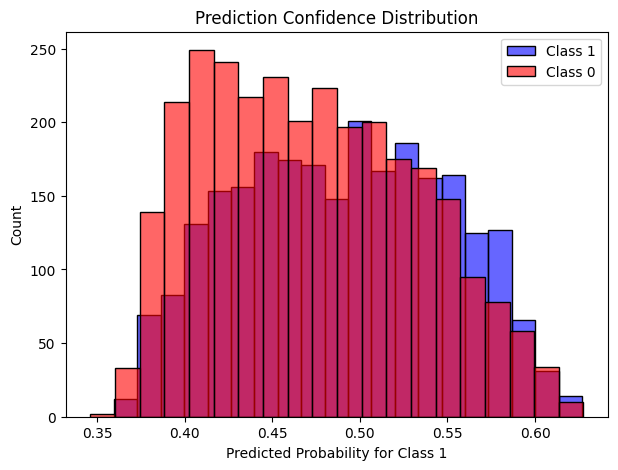

In [15]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Testing
model.eval()
all_predictions = []
true_labels = []
all_probs = []  # Store probabilities for confidence analysis

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        
        # Get predicted class and probabilities
        probs = torch.softmax(outputs, dim=1)  # Convert logits to probabilities
        _, predicted = torch.max(outputs.data, 1)
        
        all_predictions.extend(predicted.cpu().numpy())
        true_labels.extend(batch_y.cpu().numpy())
        all_probs.extend(probs.cpu().numpy()[:, 1])  # Store probabilities for class 1

# Convert to numpy arrays
true_labels = np.array(true_labels)
all_predictions = np.array(all_predictions)
all_probs = np.array(all_probs)

print(f"Accuracy: {accuracy_score(true_labels, all_predictions):.4f}")
print(classification_report(true_labels, all_predictions, zero_division=0))

conf_matrix = confusion_matrix(true_labels, all_predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Down(Class 0)", "Up(Class 1)"], yticklabels=["Down(Class 0)", "Up(Class 1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

plt.figure(figsize=(7, 5))
sns.histplot(all_probs[true_labels == 1], color="blue", label="Class 1", bins=20, alpha=0.6)
sns.histplot(all_probs[true_labels == 0], color="red", label="Class 0", bins=20, alpha=0.6)
plt.xlabel("Predicted Probability for Class 1")
plt.ylabel("Count")
plt.title("Prediction Confidence Distribution")
plt.legend()
plt.show()

Random Prediction Accuracy: 0.5066
              precision    recall  f1-score   support

           0       0.54      0.50      0.52      2914
           1       0.47      0.51      0.49      2520

    accuracy                           0.51      5434
   macro avg       0.51      0.51      0.51      5434
weighted avg       0.51      0.51      0.51      5434



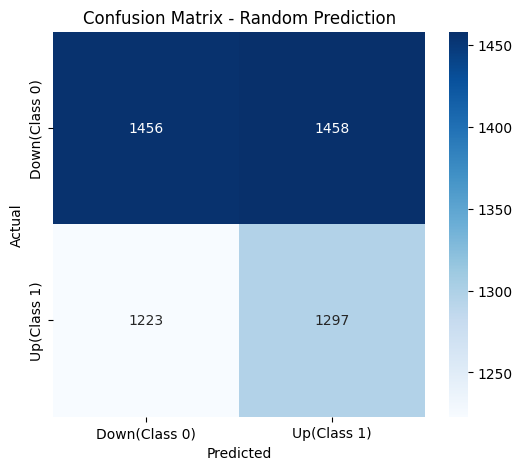

In [28]:
# Baseline strategy: Random prediction
random_predictions = np.random.randint(0, 2, size=len(true_labels))
print(f"Random Prediction Accuracy: {accuracy_score(true_labels, random_predictions):.4f}")
print(classification_report(true_labels, random_predictions, zero_division=0))

conf_matrix_random = confusion_matrix(true_labels, random_predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_random, annot=True, fmt="d", cmap="Blues", xticklabels=["Down(Class 0)", "Up(Class 1)"], yticklabels=["Down(Class 0)", "Up(Class 1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Prediction")
plt.show()

Most Common Class Prediction Accuracy: 0.5363
              precision    recall  f1-score   support

           0       0.54      1.00      0.70      2914
           1       0.00      0.00      0.00      2520

    accuracy                           0.54      5434
   macro avg       0.27      0.50      0.35      5434
weighted avg       0.29      0.54      0.37      5434



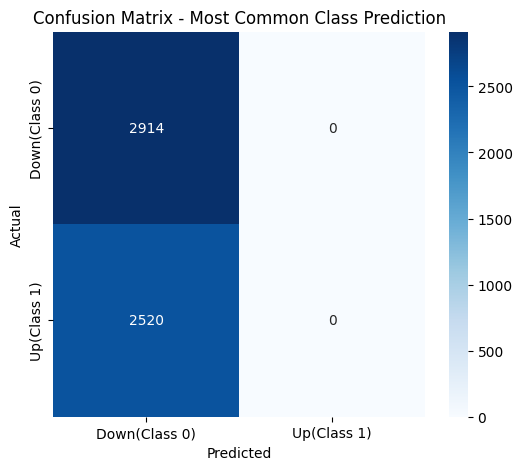

In [ ]:
train_labels = []
for _, batch_y in train_loader:
    train_labels.extend(batch_y.cpu().numpy())
train_labels = np.array(train_labels)
most_common_class = np.bincount(train_labels).argmax()
most_common_predictions = np.full_like(true_labels, most_common_class)
print(f"Most Common Class Prediction Accuracy: {accuracy_score(true_labels, most_common_predictions):.4f}")
print(classification_report(true_labels, most_common_predictions, zero_division=0))

conf_matrix_most_common = confusion_matrix(true_labels, most_common_predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_most_common, annot=True, fmt="d", cmap="Blues", xticklabels=["Down(Class 0)", "Up(Class 1)"], yticklabels=["Down(Class 0)", "Up(Class 1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Most Common Class Prediction")
plt.show()